In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import six
project_path = os.getcwd() + '/../'
sys.path.append(project_path + "utils")

import sklearn.metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.grid_search import GridSearchCV
import sklearn
from sklearn.externals import joblib
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

import function
import preprocessing
import local_bayes
import visualize
import metrics

In [3]:
sys.path.append(project_path + "models/cnn")
import cnn

# nearest points

In [4]:
save_data_dir = '../data/bookmark/'
train_0_0 = numpy.load(save_data_dir + '0_test/0_fold/0_train.npz')
test_0_0 = numpy.load(save_data_dir + '0_test/0_fold/0_test.npz')

In [5]:
new_tr = train_0_0['x'][:1000]
new_te = test_0_0['x'][0]

In [30]:
nn_num=20
data_dim=30
max_dist=50

In [31]:
localbayes = local_bayes.LocalBayes(nn_num=nn_num, data_dim=data_dim, max_dist=max_dist)

In [8]:
nn_dist_ls, nn_ts_ls = localbayes.get_nearest_n(train_0_0['x'], new_te)

In [9]:
len(nn_ts_ls)

20

In [10]:
numpy.array(nn_ts_ls)

array([[ 7,  7,  5,  2,  1,  8,  8,  5,  3,  1,  2,  2,  2,  2,  5,  2,  3,
         4,  2,  4,  2,  3,  2,  5,  0,  1,  3,  1,  1,  1],
       [ 1,  5,  2,  2,  3,  7,  3,  2,  1,  1,  2,  3,  2,  2,  1,  3,  4,
         0,  3,  0,  3,  0,  1,  1,  0,  4,  1,  1,  0,  3],
       [ 1,  5,  2,  8,  5,  3,  1,  2,  3,  0,  3,  4,  1,  2,  1,  3,  1,
         5,  6,  1,  1,  1,  1,  2,  3,  2,  5,  0,  0,  1],
       [15,  9,  6,  5,  6,  6,  2,  2,  0,  3,  3,  4,  4,  4,  3,  6,  1,
         0,  0,  3,  2,  1,  1,  1,  3,  2,  3,  2,  1,  1],
       [ 6,  2,  7,  3,  2,  1,  1,  2,  2,  3,  2,  0,  1,  2,  3,  2,  3,
         2,  4,  0,  1,  3,  0,  4,  1,  7,  3,  1,  3,  5],
       [ 2,  4,  3,  3,  4,  3,  3,  2,  2,  2,  2,  0,  2,  1,  2,  1,  0,
         2,  6,  1,  4,  2,  2,  2,  1,  2,  2,  2,  1,  2],
       [ 5,  3,  2,  1,  1,  4,  2,  1,  4,  5,  3,  2,  4,  2,  5,  2,  2,
         1,  3,  3,  5,  1,  3,  1,  1,  1,  3,  4,  2,  3],
       [10,  6,  3,  0,  1,  3,  1,  4,  

## prediction

### gradient boosting decision tree

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [12]:
max_depth = 4
n_estimators = 5000

In [13]:
bdt = joblib.load('../models/gbdt/results/bdt_%s_%s.pkl' % (max_depth, n_estimators))

In [14]:
gbdt_pred = bdt.predict_proba(numpy.array(nn_ts_ls))
gbdt_pred = gbdt_pred[:, 1].tolist()
gbdt_pred

[0.5022338609488471,
 0.49973291447093166,
 0.5018741838472378,
 0.4940985358790975,
 0.5015701998906091,
 0.501042683257283,
 0.5008645755455798,
 0.5019696955333629,
 0.5010688578274138,
 0.502235012591178,
 0.4964808177388978,
 0.4974640891506576,
 0.5028709989644301,
 0.4930356207376856,
 0.4967185141986678,
 0.5024245986888581,
 0.5014492827008376,
 0.4834579565387829,
 0.4929238787186107,
 0.500018561432291]

### CNN

In [15]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Link, Chain, ChainList

import pandas as pd
from ggplot import *

In [16]:
save_model_dir = '../models/cnn/results/awesome_100/'

In [17]:
sys.path.append(project_path + "models/cnn")
import cnn_net

In [18]:
N_test = numpy.array(nn_ts_ls).shape[0]
data_dim = test_0_0['x'].shape[1]

In [19]:
model = L.Classifier(cnn_net.tsCNN_net(data_dim))

In [20]:
serializers.load_npz(save_model_dir + "mlp.model", model)

In [21]:
def forward(x_data, model):
    x = chainer.Variable(x_data)
    h = F.max_pooling_2d(F.relu(model.conv1(x)), 2)
    h = F.max_pooling_2d(F.relu(model.conv2(h)), 2)
    h = F.relu(model.l1(h))
    y = model.l2(h)

    return y

In [22]:
nn_x = numpy.array(nn_ts_ls).reshape((N_test, 1, 1, data_dim))

In [23]:
cnn_pred = []
for i in range(0, N_test):
    x = np.asarray(nn_x[i]).reshape((1, 1, 1, data_dim)).astype(numpy.float32)
    
    pred_ = F.softmax(model.predictor(chainer.Variable(x)))
    cnn_pred.append(pred_.data[0][1])

In [24]:
cnn_pred

[0.99998808,
 0.99992847,
 0.99847454,
 0.00068034005,
 0.99983895,
 0.99991691,
 0.99835289,
 0.99988604,
 0.99999654,
 0.99999881,
 1.7782388e-06,
 0.00083333434,
 0.99995387,
 6.9481149e-07,
 0.0016020698,
 0.99998116,
 0.97835082,
 2.3233448e-34,
 2.7620164e-05,
 0.99978036]

## local bayes estimation

In [25]:
localbayes = local_bayes.LocalBayes(nn_num=20, data_dim=30, max_dist=50)

In [26]:
learner_name_ls = ['cnn', 'gbdt']
pred_proba_dict = {}
pred_proba_dict.update({'cnn':cnn_pred})
pred_proba_dict.update({'gbdt':gbdt_pred})

In [27]:
model_dict = {}
model_dict.update({'cnn':model})
model_dict.update({'gbdt':bdt})

In [28]:
len(test_0_0['x'])

2378

In [32]:
train_data_num = 1000
test_data_num = len(test_0_0['x'])
save_result_dir = '../results/nn_num=%s_train_data_num=%s_test_data_num=%s/' % (nn_num, train_data_num, test_data_num)
os.mkdir(save_result_dir)

In [33]:
lb_pred_ls, w_dict_ls = [], []
for i in xrange(test_data_num):
    test_data = test_0_0['x'][i]
    nn_dist_ls, nn_ts_array = localbayes.get_nearest_n(train_0_0['x'][:train_data_num], test_data)
    nn_pred_dict = localbayes.cal_prediction_nearest_n(test_data, nn_ts_array, learner_name_ls, model_dict)
    
    w_dict = localbayes.local_bayes_estimation(nn_pred_dict, learner_name_ls)
    w_dict_ls.append(w_dict)
    
    lb_pred = localbayes.local_bayes_predict(test_data, learner_name_ls, w_dict, model_dict)
    lb_pred_ls.append(lb_pred)
    
    sys.stdout.write('\r%d' % i)
    sys.stdout.flush()
numpy.savez(save_result_dir + 'result.npz', w=w_dict_ls, pred=lb_pred_ls)

2377

In [34]:
train_data_num = 2000
test_data_num = len(test_0_0['x'])
save_result_dir = '../results/nn_num=%s_train_data_num=%s_test_data_num=%s/' % (nn_num, train_data_num, test_data_num)
os.mkdir(save_result_dir)

In [ ]:
lb_pred_ls, w_dict_ls = [], []
for i in xrange(test_data_num):
    test_data = test_0_0['x'][i]
    nn_dist_ls, nn_ts_array = localbayes.get_nearest_n(train_0_0['x'][:train_data_num], test_data)
    nn_pred_dict = localbayes.cal_prediction_nearest_n(test_data, nn_ts_array, learner_name_ls, model_dict)
    
    w_dict = localbayes.local_bayes_estimation(nn_pred_dict, learner_name_ls)
    w_dict_ls.append(w_dict)
    
    lb_pred = localbayes.local_bayes_predict(test_data, learner_name_ls, w_dict, model_dict)
    lb_pred_ls.append(lb_pred)
    
    sys.stdout.write('\r%d' % i)
    sys.stdout.flush()
numpy.savez(save_result_dir + 'result.npz', w=w_dict_ls, pred=lb_pred_ls)

In [110]:
result = numpy.load(save_result_dir + 'result.npz')

In [47]:
result['pred'][:10]

array([  7.44085895e-08,   4.92851874e-01,   5.05491118e-01,
         5.01789553e-01,   5.01838336e-01,   5.01104980e-01,
         9.99994993e-01,   4.75736980e-01,   5.01543764e-01,
         4.60059043e-01])

In [46]:
w_dict_ls

[{'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt'

In [39]:
visual = visualize.Visualize()

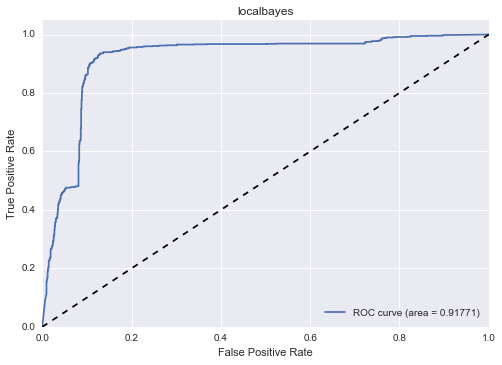

In [42]:
visual.roc_curve('localbayes', test_0_0, result['pred'])